# Cardiovascular diseases

In [1]:
%%capture
!pip install numpy pandas matplotlib seaborn scikit-learn plotly
!pip install --upgrade nbformat

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [3]:
heart = pd.read_csv("heart.csv", index_col=None, na_values=['nan'])

In [4]:
string_col = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
not_string_col = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
heart[string_col] = heart[string_col].astype('string')
heart[not_string_col] = heart[not_string_col].astype('float64')

In [5]:
# There is one record with RestingBP = 0, which is impossible. 
# We should change it to nan and then impute it later.
heart['RestingBP'] = heart['RestingBP'].replace(0, np.nan)

In [6]:
heart[heart['Cholesterol'] == 0].shape
# There are a lot of records with Cholesterol = 0, which is impossible too.
heart['Cholesterol'] = heart['Cholesterol'].replace(0, np.nan)

In [7]:
#Label Encoding for categorical columns with 2 unique values
le = preprocessing.LabelEncoder()
col_2v = ['Sex', 'ExerciseAngina']
for col in col_2v:
    heart[col] = le.fit_transform(heart[col])

In [8]:
minmax_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()

In [9]:
# Scale the Oldpeak feature using MinMaxScaler
heart['Oldpeak'] = minmax_scaler.fit_transform(heart[['Oldpeak']])

# Scale the rest of the numerical features using StandardScaler
for col in not_string_col:
    if col != 'Oldpeak':
        heart[col] = standard_scaler.fit_transform(heart[[col]])

In [10]:
# KNN imputation for missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=7)

In [11]:
# Specify the columns to exclude from imputation
exclude_columns = ['ChestPainType', 'RestingECG', 'ST_Slope']

# Perform imputation on the remaining columns
heart_tree_imputed = imputer.fit_transform(heart.drop(exclude_columns, axis=1))

# Create a dataframe of the imputed columns
heart_tree_imputed = pd.DataFrame(heart_tree_imputed, columns=heart.drop(exclude_columns, axis=1).columns)

# Concatenate the imputed columns with the excluded columns
heart_tree_imputed = pd.concat([heart_tree_imputed, heart[exclude_columns]], axis=1)

In [12]:
#Label Encoding for other categorical columns
le = preprocessing.LabelEncoder()
col_name = ['ChestPainType', 'RestingECG', 'ST_Slope']
for col in col_name:
    heart_tree_imputed[col] = le.fit_transform(heart[col])

In [13]:
#feature and target
target_tree = heart_tree_imputed['HeartDisease']
feature_tree = heart_tree_imputed.drop('HeartDisease', axis=1)

In [14]:
#splitting the data into training and testing
from sklearn.model_selection import train_test_split
feature_train_tree, feature_test_tree, target_train_tree, target_test_tree = train_test_split(feature_tree, target_tree, test_size=0.25, random_state=918*12)

Modeling

Base Accuracy: 87.391%
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Randomized Search Accuracy: 90.00%
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Grid Search Accuracy: 88.26%
RAM Consumption: 59.56640625 MB
Time Taken: 382.3185589313507 seconds


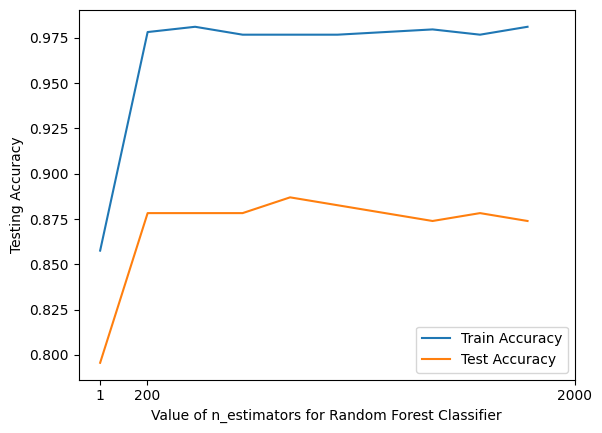

RandomForestClassifier
Training Score:  0.9811046511627907
Testing Score:  0.8739130434782608
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84        94
         1.0       0.89      0.90      0.89       136

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230



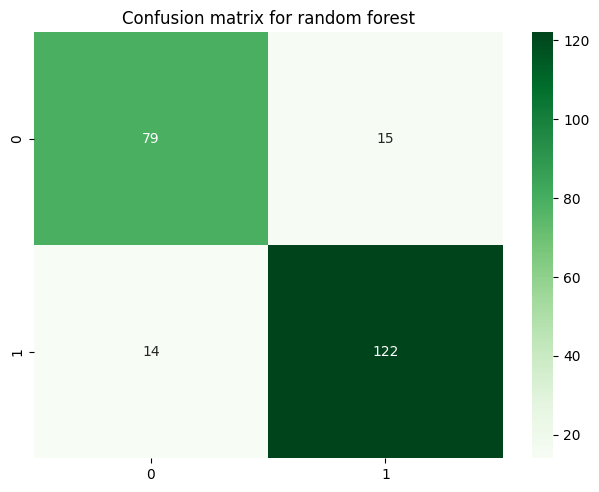

In [15]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import psutil
process = psutil.Process()
import time

start = time.time()

# Get the initial memory usage
initial_memory = process.memory_info().rss

from sklearn.ensemble import RandomForestClassifier

# Create a base model
model = RandomForestClassifier()

# Train the base model
model.fit(feature_train_tree, target_train_tree)
base_accuracy = model.score(feature_test_tree, target_test_tree)
print("Base Accuracy: %.3f%%" % (base_accuracy * 100.0))

# Define hyperparameter grids
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform randomized search to find best hyperparameters
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid,
                               n_iter=100, scoring='neg_mean_absolute_error',
                               cv=5, verbose=2, random_state=42, n_jobs=-1,
                               return_train_score=True)
rf_random.fit(feature_train_tree, target_train_tree)

# Evaluate the best model from randomized search
best_random = rf_random.best_estimator_
random_accuracy = accuracy_score(target_test_tree, best_random.predict(feature_test_tree))
print("Randomized Search Accuracy: %.2f%%" % (random_accuracy * 100))

# Extract top 5 parameter combinations from randomized search
cv_results = rf_random.cv_results_
sorted_indices = np.argsort(cv_results['mean_test_score'])[::-1]
top_5_params = [cv_results['params'][index] for index in sorted_indices[:5]]

# Extract unique values for each hyperparameter in the top 5 parameter combinations
param_values = {}
for param in random_grid:
    param_values[param] = set()

for params in top_5_params:
    for param in random_grid:
        param_values[param].add(params[param])

# Convert sets to lists for grid search
for param in param_values:
    param_values[param] = list(param_values[param])

# Create a new grid for grid search using unique parameter values
param_grid = param_values

# Perform grid search using the new grid
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, return_train_score=True)
grid_search.fit(feature_train_tree, target_train_tree)

# Evaluate the best model from grid search
best_grid = grid_search.best_estimator_
grid_accuracy = accuracy_score(target_test_tree, best_grid.predict(feature_test_tree))
print("Grid Search Accuracy: %.2f%%" % (grid_accuracy * 100))

# Create the best model using the best parameters from grid search
best_params = grid_search.best_params_
best_model = RandomForestClassifier(**best_params)

# Evaluate the best model using cross-validation
randomForest_result = cross_val_score(best_model, feature_train_tree, target_train_tree, cv=5)
train_accuracy = []
test_accuracy = []

# Vary n_estimators to plot the learning curve
for n_estimator in range(1, 2000, 200):
    best_model.set_params(n_estimators=n_estimator)
    best_model.fit(feature_train_tree, target_train_tree)
    train_prediction = best_model.predict(feature_train_tree)
    train_accuracy.append(accuracy_score(target_train_tree, train_prediction))
    test_prediction = best_model.predict(feature_test_tree)
    test_accuracy.append(accuracy_score(target_test_tree, test_prediction))
    
end = time.time()

# Get the updated memory usage
updated_memory = process.memory_info().rss

# Calculate RAM consumption in bytes
ram_consumption = updated_memory - initial_memory

# Convert RAM consumption to a more readable format
ram_consumption_mb = ram_consumption / 1024 / 1024

print(f"RAM Consumption: {ram_consumption_mb} MB")
print(f"Time Taken: {end - start} seconds")

# Plot the learning curve
plt.plot(range(1, 2000, 200), train_accuracy, label='Train Accuracy')
plt.plot(range(1, 2000, 200), test_accuracy, label='Test Accuracy')
plt.xticks((1, 2000, 200))
plt.xlabel("Value of n_estimators for Random Forest Classifier")
plt.ylabel("Testing Accuracy")
plt.legend()
plt.show()

# Print evaluation metrics and results
print("RandomForestClassifier")
train_score = best_model.score(feature_train_tree, target_train_tree)
print('Training Score: ', train_score)
test_score = best_model.score(feature_test_tree, target_test_tree)
print('Testing Score: ', test_score)
target_prediction = best_model.predict(feature_test_tree)
print(classification_report(target_test_tree, target_prediction))

# Plot confusion matrix
confusion_matrix = confusion_matrix(target_test_tree, target_prediction)
class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap='Greens', fmt='g')
plt.tight_layout()
plt.title("Confusion matrix for random forest")
plt.show()
